# Notebook A2: Classification with Neural Networks

**Authors:** Kenny Choo, Mark H. Fischer, Eliska Greplova

Adaptation for Summer School: ML in Quantum Physics and Chemistry (24.08.-03.09.2021, Warsaw) by Anna Dawid (e.g., introduction to ML libraries, hyperparameters)


## Import of the first ML library!
There are various libraries useful for ML practitioners. Among the most popular are Tensorflow (with Keras) and PyTorch. Both are pretty competitive with each other, so basically both offer the same functionalities [[source]](https://www.imaginarycloud.com/blog/pytorch-vs-tensorflow/).
- **Tensorflow** is a Python numerical library (created by the Google Brain team) with many methods being in fact high-performance C++ binaries. It can be accelerated in the Google Colaboratory by choosing TPU (Tensor Programming Units). Keras is the high-level API of TensorFlow 2, so a kind of user-friendly overlay which simplifies many operations.
- **PyTorch** is a Python library created by Facebook AI Research Lab. Before Tensorflow 2.0, PyTorch strength was a little different way of storing and building ML models, which allowed easier interaction with the models' internals. But Tensorflow 2.0 adapted to that and now the main difference is a little easier debugging of a PyTorch code than Tensorflow one.

Fun fact to confuse you even more: Keras API used to build ML models in Tensorflow looks very similar to the PyTorch way of building ML models ;)

*For curious minds:*

Also, notice that the following mapping:
\begin{align}
\mathrm{output} = \mathrm{Neural\,\,Network (input)}
\end{align}
is nothing more than lots of dot products, simple linear algebra, plus some non-linearities. Why would we need fancy libraries for that? The magical ingredient (often overlooked in the scientific community) is the automatic differentation. **Look out for the lecture by Lei Wang!**

In [1]:
# Tensorflow import
import tensorflow as tf
from tensorflow import keras

# Helper Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

print(tf.__version__)

2.6.0


In [2]:
# If you chose to clone GitHub repo:
!git clone https://github.com/Shmoo137/SummerSchool2021_MLinQuantum
folder = "/content/SummerSchool2021_MLinQuantum/A - Phase Classification (by Eliska Greplova)/Ising_data"

Cloning into 'SummerSchool2021_MLinQuantum'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 21 (delta 7), reused 19 (delta 5), pack-reused 0
Unpacking objects: 100% (21/21), done.


In this notebook we will repeat the exercise from the notebook `01_Unsupervised_learning` on using data analysis to try to identify different phases of matter. We have seen that sometimes clustering can be really powerful tool, but sometimes it does not work too well. Here, we will learn how to accomplish the same task using neural networks and see if they can do better.

# Example 1: Ising Spin Configuration Classification


The Ising model is given by the (classical) Hamiltonian:

\begin{align}
H(\boldsymbol{\sigma}) = -\sum_{<ij>} \sigma_{i}\sigma_{j},
\end{align}
where the spins $\sigma_{i} \in \lbrace -1, 1 \rbrace$ are binary variables living on the vertices of a square lattice and the sum is taken over nearest neighbours $<ij>$. 
  
At a given temperature $\beta = 1/T$, the probability of a configuration $\sigma$ is given by the Boltzmann distribution
  
\begin{align}
  P(\boldsymbol{\sigma}) = \frac{e^{-\beta H(\boldsymbol{\sigma})}}{Z},
 \end{align}
  
  where $Z$ is the partition function. This model exhibits a phase transition from the ferromagnetic phase at low tempertures to a paramagnetic phase at high temperatures. The transition temperature is $T_c \approx 2.2692$.
  
  **Task**
 
1.   Classify the ferromagnetic versus the paramagnetic phase of the Ising model
2.   Find the transition temperature
  
**Dataset**: Monte Carlo generated configurations on a 30x30 square lattice. The configuration are labelled by temperature.




## Step 1: Import data and analyze the data shape

The folder `Ising` contains Monte Carlo generated Ising configurations on the two-dimensional lattice. The data set is divided into training and test parts and corresponding label files containing the temperature, $T$, of each Monte Carlo sample.

In [3]:
N = 30 # linear dimension of the lattice 

ising_training_configs = np.load(folder + "/ising_training_configs_{0}x{0}.npy".format(N))
ising_training_labels = np.load(folder + "/ising_training_labels_{0}x{0}.npy".format(N))
ising_test_configs = np.load(folder + "/ising_test_configs_{0}x{0}.npy".format(N))
ising_test_labels = np.load(folder + "/ising_test_labels_{0}x{0}.npy".format(N))

print('train_images.shape =', ising_training_configs.shape)
print('train_labels.shape =', ising_training_labels.shape)
print('test_images.shape =', ising_test_configs.shape)
print('test_labels.shape =', ising_test_labels.shape)

train_images.shape = (1000, 30, 30)
train_labels.shape = (1000,)
test_images.shape = (1000, 30, 30)
test_labels.shape = (1000,)


## Step 2: Prepare data

At the moment, our configurations are labelled by their temperature. Since we want to learn to classify the two phases, we need to label our data by 'Ordered' (label=0) vs 'Disordered (label=1).

Let us assume that we know $1.5=T_{low}<T_{c}< T_{high} = 2.5$. Then we exclude all the data between $T_{low}$ and $T_{high}$. We label all configurations below $T_{low}$ with '0' and all those above $T_{high}$ with '1'.

In [4]:
# Assign labels according to the temperature
T_low = 1.5
T_high = 2.5

# Start with training data
train_images = []
train_labels = []

for i, label in enumerate(ising_training_labels):
    if label < T_low:
        train_images.append(ising_training_configs[i])
        train_labels.append(0)
    if label > T_high:
        train_images.append(ising_training_configs[i])
        train_labels.append(1)

# Now you should have smaller training data set, check it
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print(train_images.shape)

(600, 30, 30)


In [5]:
# Do the same with test data
test_images = []
test_labels = []
for i, label in enumerate(ising_test_labels):
    if label < T_low:
        test_images.append(ising_test_configs[i])
        test_labels.append(0)
    if label > T_high:
        test_images.append(ising_test_configs[i])
        test_labels.append(1)
# Again, less test data
test_images = np.array(test_images)
test_labels = np.array(test_labels)

## Step 3: Setup the model

Specifications of our model: 

*  Our model takes in a 30 by 30 array
*  And outputs a 2-dimensional vector

The 2-dimensional vector gives the models prediction for whether the system is ferromagnetic (i.e., $T$ < $T_c$) or paramagnetic ($T$ > $T_c$).

The model's prediction is given by the index with the largest value, i.e. argmax(output)

There are two ways to create models within Keras.

1.   Sequential Model
2.   Model class with the functional API

In both methods, the basic building block is the layer. A layer takes some input tensor and applies some transformation and returns an output tensor.

First let us explore the sequential model.

In [6]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(30, 30)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

# or equivalently
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(30, 30)))
model.add(keras.layers.Dense(32, activation=tf.nn.relu))
model.add(keras.layers.Dense(2, activation=tf.nn.softmax))

# We can also print a summary of our model by
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                28832     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 28,898
Trainable params: 28,898
Non-trainable params: 0
_________________________________________________________________


### Hyperparameters

Why 32 neurons? Good question! No one knows exactly ;) Building a ML model is a combination of educated guess, good practices, and pure luck. General rule - the simpler model (the smaller number of parameters), the better. We will encounter more quantities on whose values we need to decide to some degree arbitrarily. These quantities are called **hyperparameters**.

*Aside note for curious minds:*

While training, you optimize the parameters of the model. You check the performance of the trained model (on the subset of data called validation data) and then try to improve it by playing with hyperparameters. You can think that you optimize the model parameters on the training data and the hyperparameters on the validation data. The final test of the model performance is the test data. 

*Question:* Why shouldn't you play with your hyperparameters to improve your model performance on test data?

### The Keras Model class

Another method for building our model is to use the Keras functional API. For simple (linear) models, the Sequential method is definitely more convenient. But the functional API is useful when we want to have a  model with multiple inputs/outputs or models with shared layers. More information about the functional API can be found at https://keras.io/getting-started/functional-api-guide/

In [32]:
# We first need to instantiate the input tensor
x = keras.layers.Input(shape=(30,30))

# Then we apply layers to the input tensor which returns another tensor 
# and then the next layer and so on
f = keras.layers.Flatten()(x)
h = keras.layers.Dense(32, activation=tf.nn.relu)(f)
y = keras.layers.Dense(2, activation=tf.nn.softmax)(h)


# Define the model by the input and output tensors
model = keras.models.Model(inputs = x, outputs =y)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30, 30)]          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                28832     
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 66        
Total params: 28,898
Trainable params: 28,898
Non-trainable params: 0
_________________________________________________________________


## Step 3. Compile the model
Now that the model is defined, we need to train our model. But before doing so, there are a few details we need to specify.


1.   Loss function: we need to choose what function we want our model to minimise e.g. mean square error or cross entropy or ...
2.   Optimisation method: How we want to update the weights e.g. stochastic gradient descent or ADAM or ...
3.   Metrics: some quantity we want to keep track off while we are training, e.g. value of the loss function or the accuracy of the model...

One could also choose other loss functions or optimisers: https://keras.io/losses/, https://keras.io/optimizers/

It is always good to check the history of the training. How the training loss looked like? How the validation loss looked like? You can learn a lot from that and we will show you a very meaningful example in the end of this notebook. For now, remember it is a good practice to plot the training and validation loss!



In [8]:
# In PyTorch, this part would take more lines ;)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) 

## Step 4. Train the model

Finally we are ready to train our model. Here we basically just need to feed the data set to our model, and the model would minimise the loss function we chose and update the model parameters according to the optimisation method we specified. 

The last thing we need to choose is the number of epochs and the batch_size.


*   batch_size: this is the number of images we feed to our model in 1 iteration
*   epochs: the number of times we run through our data set.

Let's suppose batch size = 100. Then the training proceeds as follows: 

1.   Divide our dataset in batches of 100. 
2.   Take a batch of 100 samples and feed it to the model. This gives 100 output vectors from which we compute the loss function and its gradient w.r.t. to model parameters.
3. Use the gradients to update the model parameters according to the optimiser we chose 
4. Repeat steps 2 and 3 until we have cycled through to the end of the dataset. This will be the end of one epoch.

Number of iterations in one epoch = size of data set / batch_size


A few comments:

* The smaller the batch size, the faster the model trains.
* The smaller the batch size, the more noisy the training will be.
* Some amount of noise is useful to prevent us from getting stucked in local minima.



In [9]:
# Useful plotting procedure to plot training and validation losses vs. training time (measured in so-called epochs)
def plot_history(histories, key='sparse_categorical_crossentropy'):
  plt.figure(figsize=(16,10))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

In [10]:
ising_dense_history = model.fit(train_images, train_labels, epochs = 10, batch_size = 16, validation_data=(test_images,test_labels))

Epoch 1/10
38/38 [==============================] - 1s 7ms/step - loss: 0.9207 - accuracy: 0.5717 - val_loss: 0.5876 - val_accuracy: 0.6817
Epoch 2/10
38/38 [==============================] - 0s 3ms/step - loss: 0.1253 - accuracy: 0.9700 - val_loss: 0.3888 - val_accuracy: 0.8000
Epoch 3/10
38/38 [==============================] - 0s 3ms/step - loss: 0.0415 - accuracy: 1.0000 - val_loss: 0.3203 - val_accuracy: 0.8483
Epoch 4/10
38/38 [==============================] - 0s 3ms/step - loss: 0.0223 - accuracy: 1.0000 - val_loss: 0.2871 - val_accuracy: 0.8667
Epoch 5/10
38/38 [==============================] - 0s 3ms/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.2649 - val_accuracy: 0.8767
Epoch 6/10
38/38 [==============================] - 0s 3ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.2477 - val_accuracy: 0.8850
Epoch 7/10
38/38 [==============================] - 0s 3ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.2351 - val_accuracy: 0.8883
Epoch 8/10
38/38 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


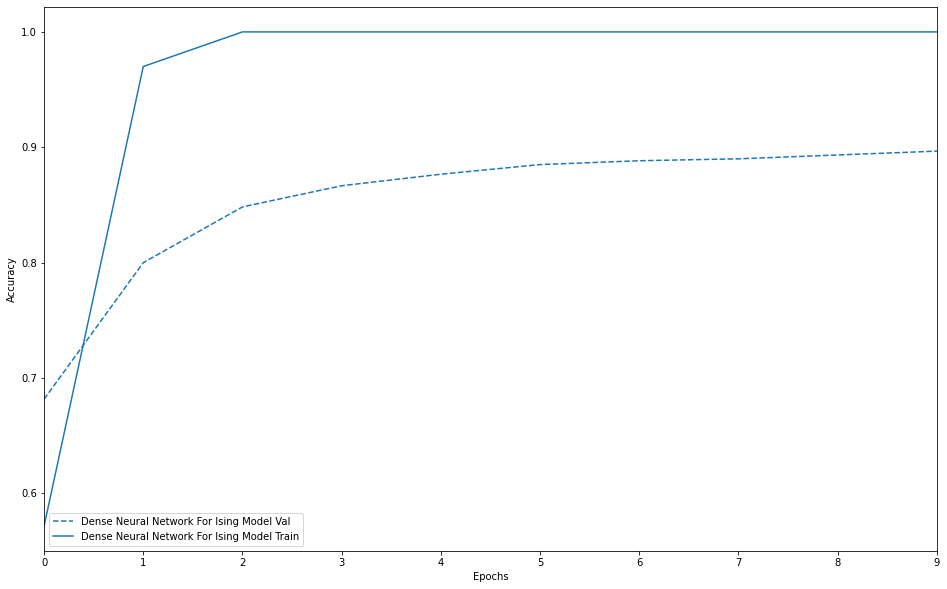

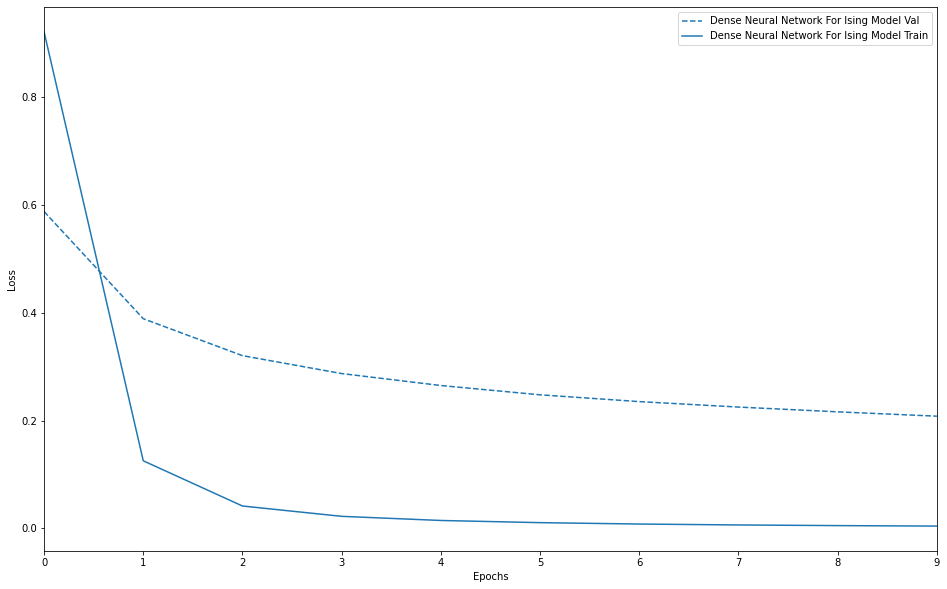

In [11]:
# See how the training looked like:
print(ising_dense_history.history.keys())
# summarize history for accuracy
plot_history([('Dense Neural Network for Ising model', ising_dense_history)], 'accuracy')
# summarize history for loss function value
plot_history([('Dense Neural Network for Ising model', ising_dense_history)], 'loss')

### Can you tell something out of these plots?

## Step 5. Evaluate our model
Now that our model is trained, we can test our model on the configurations we have not yet seen (ising_test_configs). 

In [12]:
loss, acc = model.evaluate(test_images, test_labels)

print('loss on test set =', loss)
print('accuracy on test set =', acc)

19/19 [==============================] - 0s 1ms/step - loss: 0.2080 - accuracy: 0.8967
loss on test set = 0.2080460786819458
accuracy on test set = 0.8966666460037231


We can also get the output of our model on individual configurations using the predict method. We can then use this output to see where the model would predict $T_c$ to be.

In [13]:
prediction = model.predict(ising_test_configs)
print(prediction)

[[9.9860328e-01 1.3967409e-03]
 [9.9919659e-01 8.0343115e-04]
 [9.9826425e-01 1.7357259e-03]
 ...
 [2.0609856e-01 7.9390144e-01]
 [4.2372374e-03 9.9576277e-01]
 [1.8319632e-01 8.1680369e-01]]


To evaluate where the model predicts $T_c$ to be, we average the prediction for all the configurations for a given temperature. 

We also calculate the absolute value of the magnetization ($m=|\sum \sigma_i|$) for comparison, since we know that this is our order parameter.

In [14]:
Temps = list(np.sort(list(set(ising_test_labels))))
NT = len(Temps)
phase1 = np.zeros(NT)
phase2 = np.zeros(NT)
points = np.zeros(NT)
m = np.zeros(NT)
lastT = 0.
for i, T in enumerate(ising_test_labels):
    j = Temps.index(T)
    phase1[j]+=prediction[i:i+1, 0][0]
    phase2[j]+=prediction[i:i+1, 1][0]
    m[j] += abs(np.mean(ising_test_configs[i]))
    points[j]+=1.

for j in range(NT):
    phase1[j] /= points[j]
    phase2[j] /= points[j]
    m[j] /= points[j]

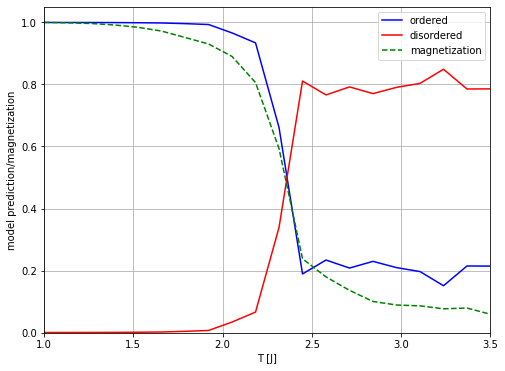

In [15]:
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(Temps, phase1, 'b', label='ordered')
plt.plot(Temps, phase2, 'r', label='disordered')
plt.plot(Temps, m, 'g--', label="magnetization")
plt.legend()
plt.ylim(0, 1.05)
plt.xlim(1,3.5)
plt.xlabel('T [J]')
plt.ylabel('model prediction/magnetization')
plt.grid()
plt.show()

We can now estimate the location of the transition. Lets define this to be the location where our model's prediction drops to  0.5 .

In [16]:
index = (np.abs(phase1 - 0.5)).argmin()
tc = Temps[index]

print("Estimated Transition Temp =", tc)

Estimated Transition Temp = 2.3157894736842106


The exact transition temperature in the thermodynamic limit is  2.2692 , so our result is not so bad considering finite size effects. If we look again at the above plot, we can see that the curves coincide relatively nicely with the average magnetization, this suggest that the network is indeed learning the magnetization, i.e. it is computing the magnetization and using it to make its prediction.

# Example 2: Ising Hamiltonian with the local constraint

In the previous example, we classified spin configurations of the simple Ising model. That was a relatively easy task given that we know that there's a global order paramter, i.e., the magnetization that distinguishes the two phases the model has.

In the following, we will look at spin configurations coming from a different model on which the dense neural network spectacularly fails. In this model, Ising spins live on the edges of a square lattice (see Figs. below). The Hamiltonian then favors even down and up spins around a square. If the number is odd, a pentalty is paid. The Hamiltonian is given by

\begin{align}
H(\boldsymbol{\sigma}) = -\sum_{p} \prod_{i \in p}\sigma_{i},
\end{align}
where we sum over the plaquettes $p$ of the square lattice.

This model does not have a finite temperature transition. We thus want to train a network to distinguish the (highly degenerate) ground states of this system from any excited state.

In [17]:
N = 16 # linear dimension of the lattice 

ilgt_training_configs = np.load(folder + "/ilgt_training_configs.npy".format(N))
ilgt_training_labels = np.load(folder + "/ilgt_training_labels.npy".format(N))
ilgt_test_configs = np.load(folder + "/ilgt_test_configs.npy".format(N))
ilgt_test_labels = np.load(folder + "/ilgt_test_labels.npy".format(N))

print('train_images.shape =', ilgt_training_configs.shape)
print('train_labels.shape =', ilgt_training_labels.shape)
print('test_images.shape =', ilgt_test_configs.shape)
print('test_labels.shape =', ilgt_test_labels.shape)

train_images.shape = (2000, 16, 16, 2)
train_labels.shape = (2000,)
test_images.shape = (2000, 16, 16, 2)
test_labels.shape = (2000,)


## Dense Neural Network

In [18]:
## Let's build this dense neural network (DNN) ourselves now!
## We want (for start) a DNN which takes an input of certain shape
## then let's go with hidden layer of 100 neurons and ReLU
## then output layer (# of neurons = # of classes in the problem) with Softmax

# Dense network
dense = keras.Sequential([
    keras.layers.Flatten(input_shape=(16, 16, 2)),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

# Compile the model with an Adam optimiser
# Take sparse categorical cross entropy as a loss function
# And choose metrics (measures of model performace), e.g., accuracy and loss function above
dense.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy','sparse_categorical_crossentropy']) 

# Print a summary of the model
dense.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               51300     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 202       
Total params: 51,502
Trainable params: 51,502
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Now let's train our DNN!
dense_history = dense.fit(ilgt_training_configs, ilgt_training_labels, epochs = 50, 
                          validation_data=(ilgt_test_configs, ilgt_test_labels), 
                          batch_size = 32, verbose = 1)

Epoch 1/50
63/63 [==============================] - 1s 6ms/step - loss: 0.8804 - accuracy: 0.5080 - sparse_categorical_crossentropy: 0.8804 - val_loss: 0.8321 - val_accuracy: 0.4950 - val_sparse_categorical_crossentropy: 0.8321
Epoch 2/50
63/63 [==============================] - 0s 4ms/step - loss: 0.5298 - accuracy: 0.7360 - sparse_categorical_crossentropy: 0.5298 - val_loss: 0.8462 - val_accuracy: 0.4950 - val_sparse_categorical_crossentropy: 0.8462
Epoch 3/50
63/63 [==============================] - 0s 4ms/step - loss: 0.3914 - accuracy: 0.8560 - sparse_categorical_crossentropy: 0.3914 - val_loss: 0.8945 - val_accuracy: 0.4885 - val_sparse_categorical_crossentropy: 0.8945
Epoch 4/50
63/63 [==============================] - 0s 3ms/step - loss: 0.2726 - accuracy: 0.9495 - sparse_categorical_crossentropy: 0.2726 - val_loss: 0.9481 - val_accuracy: 0.5000 - val_sparse_categorical_crossentropy: 0.9481
Epoch 5/50
63/63 [==============================] - 0s 4ms/step - loss: 0.1781 - accurac

In [20]:
# How does the DNN performs?
loss,acc,_ = dense.evaluate(ilgt_test_configs, ilgt_test_labels)

print('Dense Network')
print('loss on test set =', loss)
print('accuracy on test set = {}%'.format(acc*100))

63/63 [==============================] - 0s 1ms/step - loss: 1.9303 - accuracy: 0.4950 - sparse_categorical_crossentropy: 1.9303
Dense Network
loss on test set = 1.930293321609497
accuracy on test set = 49.50000047683716%


### WOW! What just happened? Can you guess by checking the training history? Plot the accuracy and loss for training and validation data...

In [21]:
# See how the training looked like:


Conclusions coming from this notebook's experiments are in the end ;)

## Dense Neural Network with Dropout

Try adding a layer called Dropout (`keras.layers.Dropout(p)`), where p is the probability of setting a neuron to zero during the training. See `p=0.3`. Later check other values!

In [22]:
# DNN with Dropout
dense_dropout = keras.Sequential([
    keras.layers.Flatten(input_shape=(16, 16, 2)),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

# Compile the model with an optimiser
dense_dropout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy','sparse_categorical_crossentropy']) 

# Print a summary of the model
dense_dropout.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               51300     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 202       
Total params: 51,502
Trainable params: 51,502
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Train the DNN with dropout (and plot accuracies and losses)
dropout_history = dense_dropout.fit(ilgt_training_configs, ilgt_training_labels, epochs = 50, 
                          validation_data=(ilgt_test_configs, ilgt_test_labels), 
                          batch_size = 64, verbose = 0)

dict_keys(['loss', 'accuracy', 'sparse_categorical_crossentropy', 'val_loss', 'val_accuracy', 'val_sparse_categorical_crossentropy'])


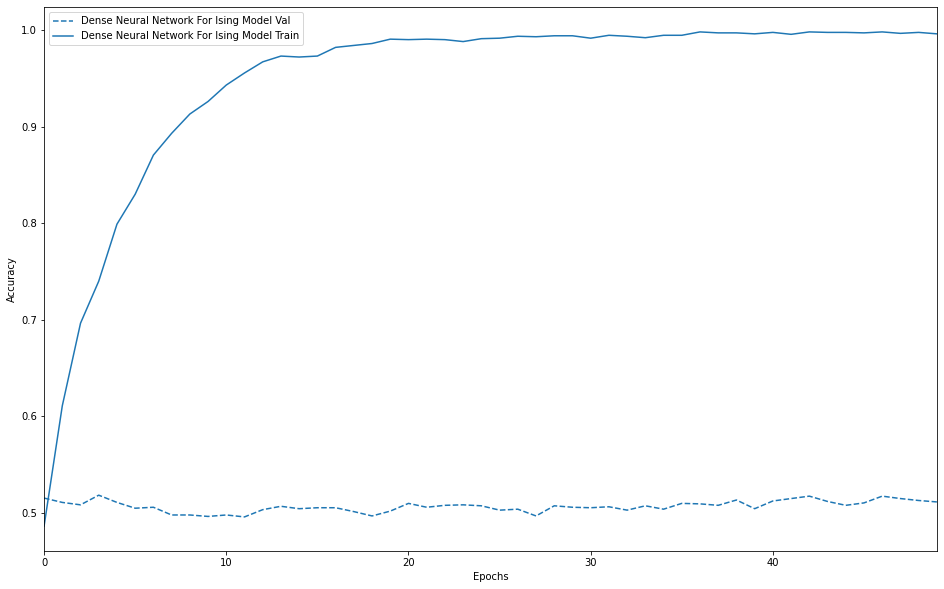

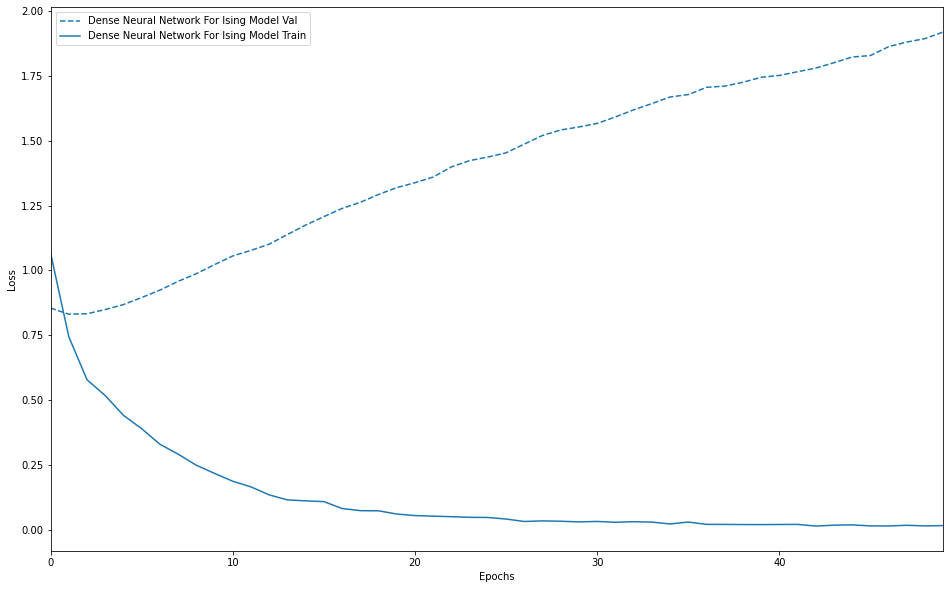

In [24]:
# See how the training looked like:
print(dropout_history.history.keys())
# summarize history for accuracy
plot_history([('Dense Neural Network for Ising model', dropout_history)], 'accuracy')
# summarize history for loss function value
plot_history([('Dense Neural Network for Ising model', dropout_history)], 'loss')

In [25]:
# DNN with Dropout
loss,acc,_ = dense_dropout.evaluate(ilgt_test_configs, ilgt_test_labels)

print('Dense Network with dropout')
print('loss on test set =', loss)
print('accuracy on test set = {}%'.format(acc*100))

63/63 [==============================] - 0s 1ms/step - loss: 1.9201 - accuracy: 0.5115 - sparse_categorical_crossentropy: 1.9201
Dense Network with dropout
loss on test set = 1.9201250076293945
accuracy on test set = 51.15000009536743%


## Convolutional Neural Networks

Finally, let's play with one of the most powerful ML models, designed especially for images (i.e., for higher-dimentional data where spatial dependence is a significant feature).

What convolutional layers do?

![Alt Text](https://miro.medium.com/max/789/0*jLoqqFsO-52KHTn9.gif)

The yellow matrix is called a kernel, and its size is one of the hyperparameters. It moves around the green (input) image with step defined by `stride` (here = 1), and how it behaves at the edges of the image is called `padding`. The resulting convolved image is an input to a next layer.

In [26]:
# we want to be able to use different kernel sizes and compare
def convolutional_model(kernel_size):
    input_size = 16+2*(kernel_size-1)
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(16, (kernel_size, kernel_size), strides=(1,1), padding='Valid', input_shape=(input_size,input_size,2), activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(2, activation='softmax'))

    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy','sparse_categorical_crossentropy'])
    
    return model

In [27]:
kernel_size = 2
model = convolutional_model(kernel_size)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 17, 17, 16)        144       
_________________________________________________________________
flatten_5 (Flatten)          (None, 4624)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 37000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 18        
Total params: 37,162
Trainable params: 37,162
Non-trainable params: 0
_________________________________________________________________


We have introduced here two new layers. Lets briefly understand what each layer does.

1.  **Convolutional**: This layer applies 32 kernels of size 2 by 2 over the input image. There are 2 paddings one can choose from 'valid' or 'same'. For our purpose, we need periodic boundary conditions and we thus use 'Valid', which means it does not add additional 'pixels' around the configuration. We instead add the padding ourselves (see below).
```
 keras.layers.Conv2D(32, kernel_size=(2,2), strides=(1, 1), padding = 'Valid', activation=tf.nn.relu)
```


2.  **Dropout**: This layers drops the nodes in the layer above with a 50% probability.
```
keras.layers.Dropout(0.5)
```
Note that this layer is only applied during training. When evaluating or predicting on test samples, this layer is not applied.

For more information about layer check out the keras documentation: https://keras.io/layers/about-keras-layers/


One final note on the input shape: While for the (first) dense layer we can define just about any shape, the input shape for the convolutional layer is necessarily N x M x C, where C is the number of channels. If the input available has only a single channel, i.e., its shape is N x M, an additional axis with dimension 1 needs to be added for it to work.

In [28]:
# Create the periodic padding for training and test configurations
def create_periodic_padding(configs, kernel_size):
    N = np.shape(configs)[1]
    padding = kernel_size-1
    x = []
    for config in configs:
        padded = np.zeros((N+2*padding, N+2*padding, 2))
        # lower left corner
        padded[:padding,:padding, :] = config[N-padding:,N-padding:,:]
        # lower middle
        padded[padding:N+padding, :padding, :] = config[:,N-padding:,:]
        # lower right corner
        padded[N+padding:, :padding, :] = config[:padding, N-padding:, :]
        # left side
        padded[:padding, padding:N+padding, :] = config[N-padding:, :, :]
        # center
        padded[padding:N+padding, padding:N+padding, :] = config[:,:,:]
        # right side
        padded[N+padding:, padding:N+padding, :] = config[:padding, :, :]
        # top left corner
        padded[:padding, N+padding:,:] = config[N-padding:, :padding, :]
        # top middle
        padded[padding:N+padding, N+padding:, :] = config[:, :padding, :]
        # top right corner
        padded[N+padding:, N+padding:, :] = config[:padding, :padding, :]
        x.append(padded)
    return np.array(x)

x_n = create_periodic_padding(ilgt_training_configs,kernel_size)
test_x_n = create_periodic_padding(ilgt_test_configs, kernel_size)

In [29]:
convolutional_history = model.fit(x_n,ilgt_training_labels,epochs=50, 
                                  validation_data=(test_x_n, ilgt_test_labels), 
                                  batch_size=32, verbose=1)

Epoch 1/50
63/63 [==============================] - 1s 10ms/step - loss: 0.6988 - accuracy: 0.4960 - sparse_categorical_crossentropy: 0.6988 - val_loss: 0.6932 - val_accuracy: 0.4995 - val_sparse_categorical_crossentropy: 0.6932
Epoch 2/50
63/63 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.4965 - sparse_categorical_crossentropy: 0.6928 - val_loss: 0.6935 - val_accuracy: 0.5005 - val_sparse_categorical_crossentropy: 0.6935
Epoch 3/50
63/63 [==============================] - 0s 7ms/step - loss: 0.6865 - accuracy: 0.5210 - sparse_categorical_crossentropy: 0.6865 - val_loss: 0.6937 - val_accuracy: 0.5090 - val_sparse_categorical_crossentropy: 0.6937
Epoch 4/50
63/63 [==============================] - 0s 7ms/step - loss: 0.6690 - accuracy: 0.5835 - sparse_categorical_crossentropy: 0.6690 - val_loss: 0.7017 - val_accuracy: 0.5120 - val_sparse_categorical_crossentropy: 0.7017
Epoch 5/50
63/63 [==============================] - 0s 7ms/step - loss: 0.6407 - accura

In [30]:
# Convolutional Network
loss, acc, _ = model.evaluate(test_x_n, ilgt_test_labels, verbose=0)
print('Convolutional Network with dropout')
print('loss on test set =', loss)
print('accuracy on test set = {}%'.format(acc*100))

Convolutional Network with dropout
loss on test set = 0.019261183217167854
accuracy on test set = 99.59999918937683%


## Conclusions

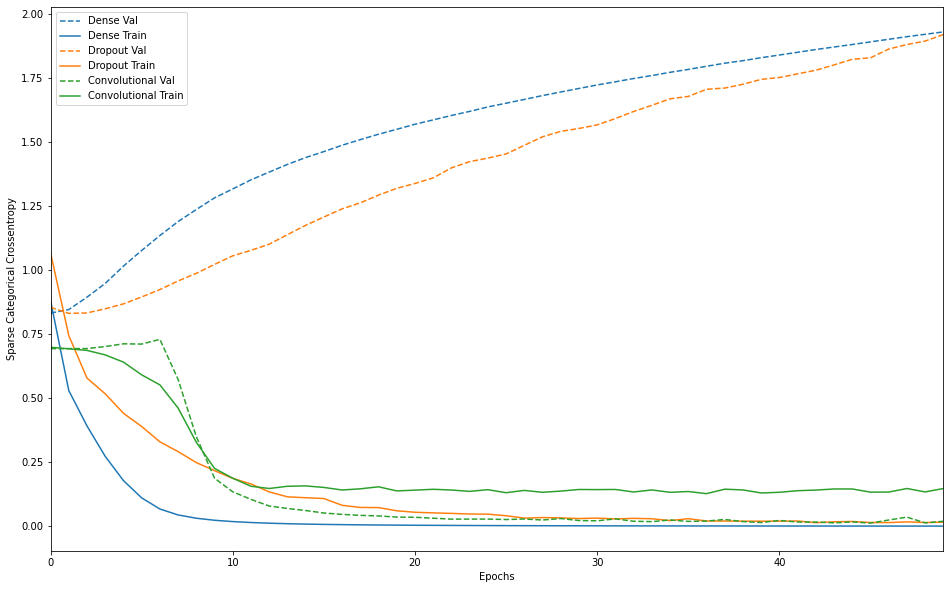

In [31]:
plot_history([('Dense',dense_history),
              ('Dropout', dropout_history),
              ('Convolutional', convolutional_history)])

From the above plot, we can observe a few things. 

1.  **Dense Network (Blue**):  Very quickly, the loss is decreasing on the training set, but it is actually increasing for the validation set. There is a large and widening gap between validation loss and training loss.  (We are overfitting)
2. **Dense Network with dropout (green)**  By adding a dropout layer, one can see that the gap between the training and validation loss is smaller. For many applications, adding a dropout layer can help avoiding overfitting. This is, however, not enough here.
2.   **Convolutional Network (Red)**: Both the validation and the training losses are decreasing for all epochs (No overfitting).
3. Even though the dense network has a lower loss on the training set, the loss on the validation set is much higher than the convolutional network.

We can see that the dropout layer is definitely helps to prevent the overfitting.

Some ways to combat overfitting:

1. **Dropout layers**: This prevents the model from co-adapting or memorising data
2. **Adding regularisation** terms to cost function, e.g. to penalise large parameters: This limits the power of the model by preventing it from exploring large parameters, e.g.
```
l2_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, kernel_regularizer=keras.regularizers.l2(0.001), activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.softmax)
])
```
This would add a L2 regularisation term to the loss function, i.e. L2 = ||w||^2 where w represents the weights of the corresponding layer.


3. **Early stopping**: Here we simply stop training when we have achieved a satisfactory validation accuracy or loss. For example, in the dense network we trained above, it is probably a good idea to stop the training after aroud 11 epochs.

